# Tutorial - Step2 : Finetuning with property-based reward

## 1. Import requirements

In [1]:
import os
import sys
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from COMA.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from COMA.vae import SmilesAutoencoder, RewardFunctionLogP
from COMA.properties import penalized_logp, similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [5]:
PROPERTY_NAME = "logp04"

SCORING_PROPERTY_FT = penalized_logp
SCORING_TANIMOTO_FT = similarity

## Configure the parameters of a reward function for the target property
threshold_property = 0.
threshold_similarity = 0.3

## 4. Set directories (for inputs and outputs)

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_4-1_{PROPERTY_NAME.upper()}_pretraining"

In [7]:
output_dir = f"outputs_4-2_{PROPERTY_NAME.upper()}_finetuning"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_data_dir, "rdkit_valid.txt")

In [8]:
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)
dataset.save_char2idx(filepath_char2idx)
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load a pretrained generator of COMA

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [12]:
reward_ft = RewardFunctionLogP(similarity_ft=SCORING_TANIMOTO_FT,
                               scoring_ft=SCORING_PROPERTY_FT,
                               threshold_property=threshold_property,
                               threshold_similarity=threshold_similarity)

## 9. Train

In [13]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft,
                                                         validation_dataset=dataset_valid,
                                                         checkpoint_filepath=filepath_checkpoint)

df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

[000000/002000]  loss: 0.437  reward: 1.146  similarity: 0.547  property[0]: 1.146  valid_ratio(va): 0.935  similarity(va): 0.391  property(va): 1.070
[000010/002000]  loss: 0.327  reward: 1.814  similarity: 0.536  property[0]: 1.814  valid_ratio(va): 0.965  similarity(va): 0.380  property(va): 1.845
[000020/002000]  loss: 0.347  reward: 2.417  similarity: 0.520  property[0]: 2.417  valid_ratio(va): 0.990  similarity(va): 0.349  property(va): 2.693
[000030/002000]  loss: 0.412  reward: 2.518  similarity: 0.505  property[0]: 2.518  valid_ratio(va): 1.000  similarity(va): 0.335  property(va): 3.040
[000040/002000]  loss: 0.423  reward: 2.931  similarity: 0.502  property[0]: 2.931  valid_ratio(va): 1.000  similarity(va): 0.329  property(va): 3.171
[000050/002000]  loss: 0.368  reward: 2.994  similarity: 0.481  property[0]: 2.994  valid_ratio(va): 1.000  similarity(va): 0.334  property(va): 3.236
[000060/002000]  loss: 0.343  reward: 2.812  similarity: 0.514  property[0]: 2.812  valid_rati

[000550/002000]  loss: 0.437  reward: 3.448  similarity: 0.473  property[0]: 3.448  valid_ratio(va): 1.000  similarity(va): 0.317  property(va): 3.694
[000560/002000]  loss: 0.416  reward: 3.201  similarity: 0.466  property[0]: 3.201  valid_ratio(va): 1.000  similarity(va): 0.313  property(va): 3.725
[000570/002000]  loss: 0.424  reward: 3.428  similarity: 0.467  property[0]: 3.428  valid_ratio(va): 1.000  similarity(va): 0.313  property(va): 3.681
[000580/002000]  loss: 0.414  reward: 3.553  similarity: 0.480  property[0]: 3.553  valid_ratio(va): 1.000  similarity(va): 0.312  property(va): 3.711
[000590/002000]  loss: 0.418  reward: 3.425  similarity: 0.463  property[0]: 3.425  valid_ratio(va): 1.000  similarity(va): 0.314  property(va): 3.709
[000600/002000]  loss: 0.438  reward: 3.631  similarity: 0.473  property[0]: 3.631  valid_ratio(va): 1.000  similarity(va): 0.315  property(va): 3.704
[000610/002000]  loss: 0.402  reward: 3.368  similarity: 0.465  property[0]: 3.368  valid_rati

[001100/002000]  loss: 0.434  reward: 3.509  similarity: 0.469  property[0]: 3.509  valid_ratio(va): 1.000  similarity(va): 0.313  property(va): 3.797
[001110/002000]  loss: 0.460  reward: 3.350  similarity: 0.472  property[0]: 3.350  valid_ratio(va): 1.000  similarity(va): 0.315  property(va): 3.832
[001120/002000]  loss: 0.469  reward: 3.549  similarity: 0.468  property[0]: 3.549  valid_ratio(va): 1.000  similarity(va): 0.311  property(va): 3.884
[001130/002000]  loss: 0.417  reward: 3.266  similarity: 0.466  property[0]: 3.266  valid_ratio(va): 1.000  similarity(va): 0.314  property(va): 3.847
[001140/002000]  loss: 0.440  reward: 3.562  similarity: 0.475  property[0]: 3.562  valid_ratio(va): 1.000  similarity(va): 0.316  property(va): 3.789
[001150/002000]  loss: 0.456  reward: 3.278  similarity: 0.454  property[0]: 3.278  valid_ratio(va): 1.000  similarity(va): 0.311  property(va): 3.831
[001160/002000]  loss: 0.421  reward: 3.543  similarity: 0.482  property[0]: 3.543  valid_rati

[001650/002000]  loss: 0.469  reward: 3.651  similarity: 0.464  property[0]: 3.651  valid_ratio(va): 1.000  similarity(va): 0.313  property(va): 3.877
[001660/002000]  loss: 0.476  reward: 3.586  similarity: 0.452  property[0]: 3.586  valid_ratio(va): 1.000  similarity(va): 0.313  property(va): 3.875
[001670/002000]  loss: 0.491  reward: 3.835  similarity: 0.451  property[0]: 3.835  valid_ratio(va): 1.000  similarity(va): 0.315  property(va): 3.921
[001680/002000]  loss: 0.465  reward: 3.718  similarity: 0.448  property[0]: 3.718  valid_ratio(va): 1.000  similarity(va): 0.309  property(va): 3.961
[001690/002000]  loss: 0.446  reward: 3.497  similarity: 0.464  property[0]: 3.497  valid_ratio(va): 1.000  similarity(va): 0.311  property(va): 3.962
[001700/002000]  loss: 0.422  reward: 3.484  similarity: 0.468  property[0]: 3.484  valid_ratio(va): 1.000  similarity(va): 0.310  property(va): 3.977
[001710/002000]  loss: 0.536  reward: 3.969  similarity: 0.462  property[0]: 3.969  valid_rati

## 10. Visualize for reward & loss analysis

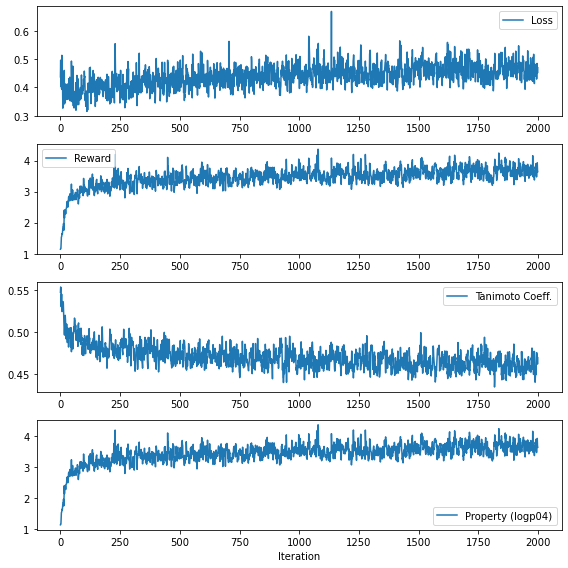

In [14]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

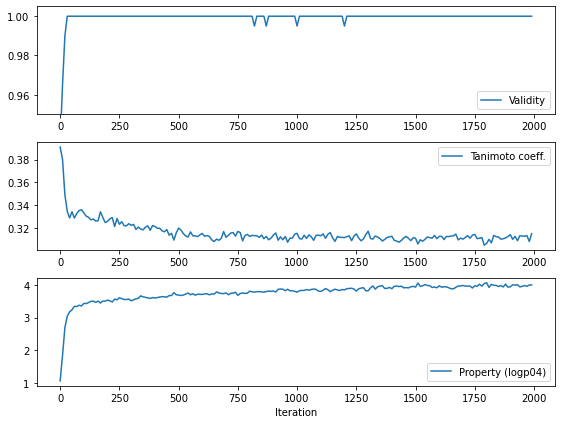

In [16]:
fig, axes = plt.subplots(3,1,figsize=(8,6))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()